# SWE Bench repeated sampling analysis notebook


In [1]:
from dataclasses import dataclass
from pathlib import Path
from typing import Set
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
from typing import Dict, List

In [2]:
NUM_TOTAL_SAMPLES = 250

SUMMARY_FILE_PATH = Path("./summary.json")

# Baseline loading

In [3]:
AIDE_RESULTS_URL = "https://raw.githubusercontent.com/swe-bench/experiments/main/evaluation/lite/20240702_codestory_aide_mixed/results/results.json"
CLAUDE_SONNET_MOATLESS_TOOLS_URL = "https://raw.githubusercontent.com/swe-bench/experiments/main/evaluation/lite/20240623_moatless_claude35sonnet/results/results.json"
GPT4_MOATLESS_TOOLS_URL = "https://raw.githubusercontent.com/swe-bench/experiments/main/evaluation/lite/20240617_moatless_gpt4o/results/results.json"

In [4]:
def fetch_results_file_and_get_resolved_instances(url) -> Set[str]:
    response = requests.get(url)
    assert response.status_code == 200

    return set(response.json()["resolved"])

In [5]:
instances_aide_resolved = fetch_results_file_and_get_resolved_instances(AIDE_RESULTS_URL)
instances_claude_sonnet_resolved = fetch_results_file_and_get_resolved_instances(CLAUDE_SONNET_MOATLESS_TOOLS_URL)
instances_gpt4_resolved = fetch_results_file_and_get_resolved_instances(GPT4_MOATLESS_TOOLS_URL)

# Data loading

In [6]:
@dataclass
class SampleResultForInstanceWithoutFlakyTests:
    resolved: bool
    patch_hash: str


@dataclass
class SampleResultForInstanceWithFlakyTests:
    resolved: bool
    patch_hash: str
    test_runs: List[bool]


# Results for a specific instance, mapping sample id to the results for that sample.
PerSampleResultsFlaky = Dict[str, SampleResultForInstanceWithFlakyTests]
PerSampleResultsNotFlaky = Dict[str, SampleResultForInstanceWithFlakyTests]

SampleResult = (
    SampleResultForInstanceWithoutFlakyTests | SampleResultForInstanceWithFlakyTests
)
PerSampleResults = Dict[str, SampleResult]

# Type hint for clarity
InstanceId = str

InstanceResults = Dict[InstanceId, PerSampleResults]


@dataclass
class SweBenchSampleData:
    instances_without_flaky_tests: Dict[InstanceId, PerSampleResultsFlaky]
    instances_with_flaky_tests: Dict[InstanceId, PerSampleResultsNotFlaky]

In [7]:
def load_data(summary_file_path) -> SweBenchSampleData:
    with open(summary_file_path) as f:
        data_as_json = json.load(f)

    assert data_as_json.keys() == {
        "instances_without_flaky_tests",
        "instances_with_flaky_tests",
    }

    instances_without_flaky_tests = {}
    for instance_id, per_sample_results in data_as_json[
        "instances_without_flaky_tests"
    ].items():

        per_sample_results_dataclasses = {}
        for run_id, sample_result in per_sample_results.items():
            assert int(run_id) < NUM_TOTAL_SAMPLES and int(run_id) >= 0
            assert sample_result.keys() == {"resolved", "patch_hash"}

            assert isinstance(sample_result["resolved"], bool)

            per_sample_results_dataclasses[run_id] = (
                SampleResultForInstanceWithoutFlakyTests(**sample_result)
            )
        instances_without_flaky_tests[instance_id] = per_sample_results_dataclasses

    instances_with_flaky_tests = {}
    for instance_id, per_sample_results in data_as_json[
        "instances_with_flaky_tests"
    ].items():

        per_sample_results_dataclasses = {}
        for run_id, sample_result in per_sample_results.items():
            assert int(run_id) < NUM_TOTAL_SAMPLES and int(run_id) >= 0
            assert sample_result.keys() == {"resolved", "test_runs", "patch_hash"}

            per_sample_results_dataclasses[run_id] = (
                SampleResultForInstanceWithFlakyTests(**sample_result)
            )
        instances_with_flaky_tests[instance_id] = per_sample_results_dataclasses

    return SweBenchSampleData(
        instances_with_flaky_tests=instances_with_flaky_tests,
        instances_without_flaky_tests=instances_without_flaky_tests,
    )

In [8]:
data = load_data(SUMMARY_FILE_PATH)

# Metrics

In [9]:
def count_num_resolved_samples(instance_data: PerSampleResults) -> int:
    num_resolved = sum([1 for data in instance_data.values() if data.resolved])
    return num_resolved


def build_instance_id_to_num_passing_map(
    instance_results: InstanceResults,
) -> Dict[InstanceId, int]:
    """Maps instance id to the number of resolved samples.

    Args:
        instance_results: results to aggregate.

    Returns:
        A dict mapping instance id to the number of samples that are correct for that instance.
    """
    instance_id_to_num_passing = {
        instance_id: count_num_resolved_samples(instance_data)
        for (instance_id, instance_data) in instance_results.items()
    }
    return instance_id_to_num_passing

In [10]:
def pass_at_k(n, c, k):
    """
    :param n: total number of samples
    :param c: number of correct samples
    :param k: k in pass@$k$

    NOTE: source is https://arxiv.org/pdf/2107.03374
    """
    if n - c < k:
        return 1.0
    return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))


def expected_pass_at_k(
    instance_id_to_num_passing: Dict[InstanceId, int]
) -> Dict[int, float]:
    """Computes expected pass at k across the given instances.

    Args:
        instance_id_to_num_passing: maps instance id to the number of samples that are correct.

    Returns:
        A dict mapping k to the pass@k.
    """
    passes_at_k = {}

    for k in range(1, NUM_TOTAL_SAMPLES + 1):
        passes = [
            pass_at_k(n=NUM_TOTAL_SAMPLES, c=num_correct, k=k)
            for num_correct in instance_id_to_num_passing.values()
        ]
        passes_at_k[k] = float(sum(passes) / len(passes))
    return passes_at_k


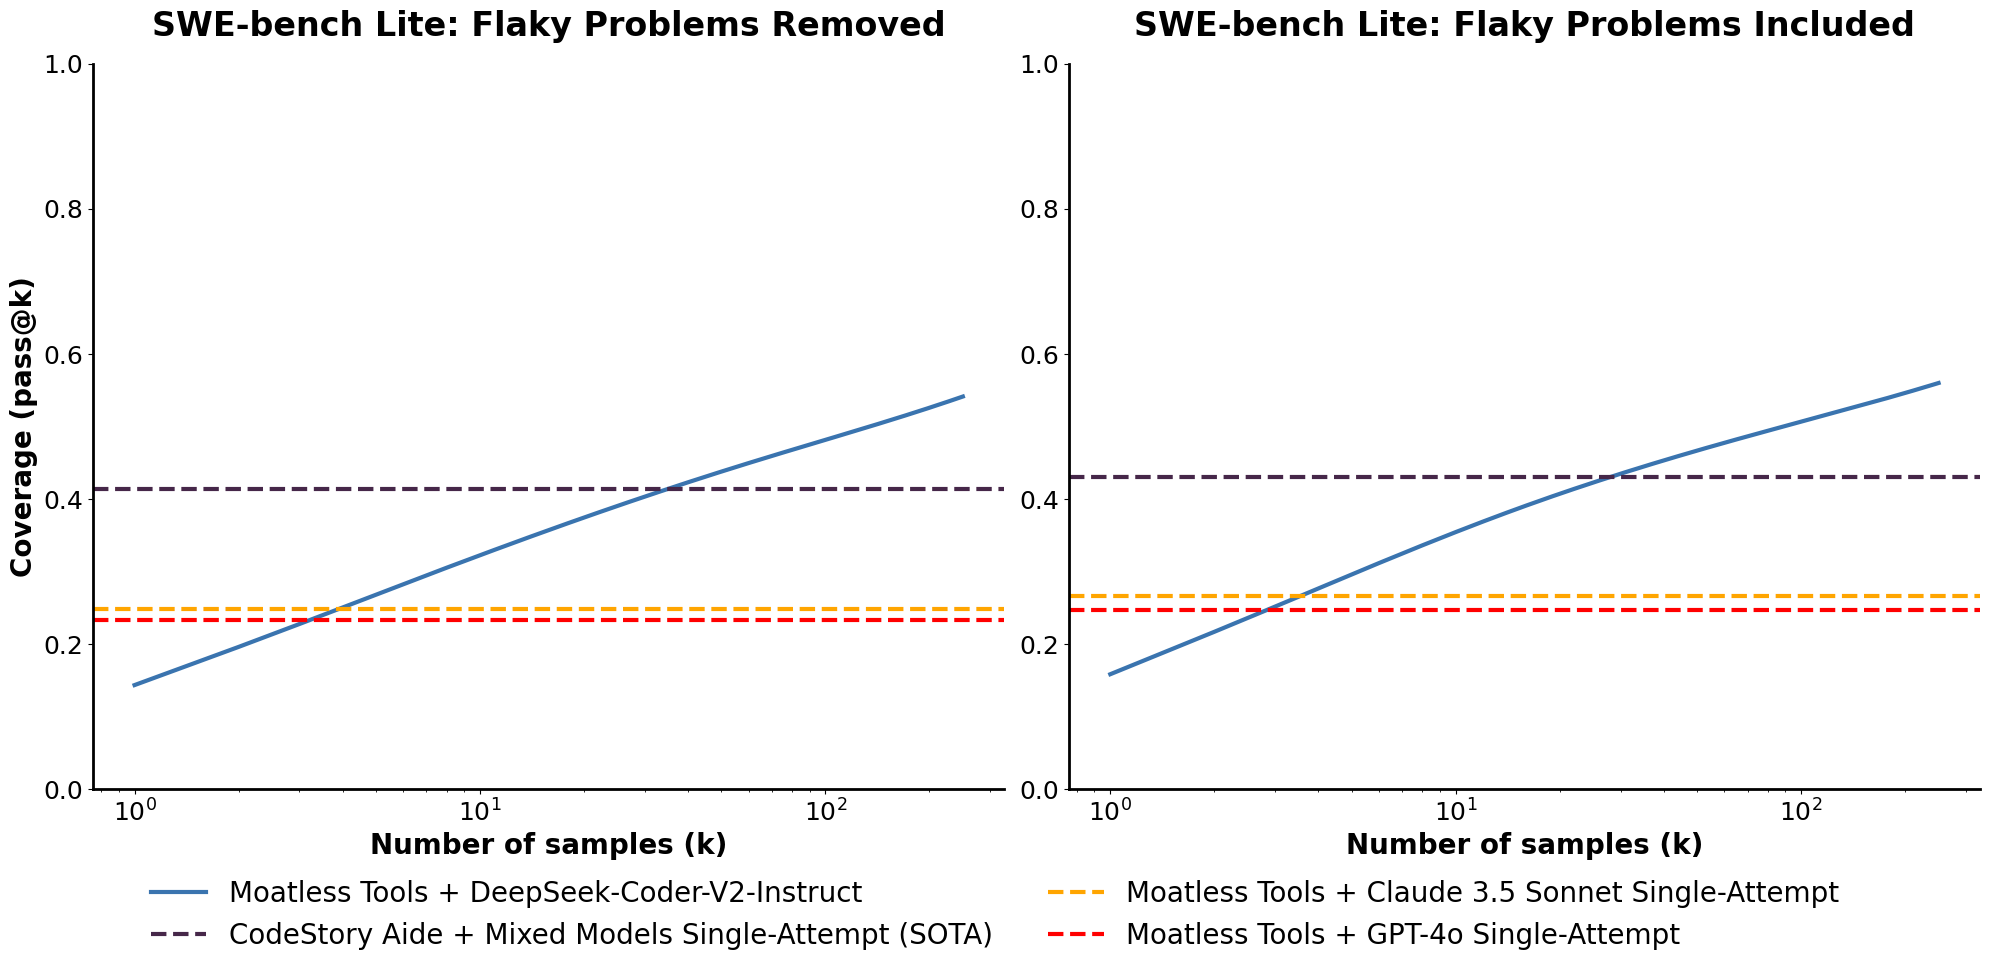

In [11]:
TITLE_SIZE = 24
LABEL_SIZE = 20
TICK_SIZE = 18
LEGEND_SIZE = 20
LINEWIDTH = 3


def plot_single_pass_at_k(ax, instance_results, title, include_ylabel=True):
    """Plots a single pass@k curve on the given axis.
    
    Args:
        ax: The matplotlib axis to plot on.
        instance_results: The instance results to plot.
        title: The title for this subplot.
        include_ylabel: Whether to include the y-axis label.
    """
    instance_id_to_num_passing = build_instance_id_to_num_passing_map(instance_results)
    passes_at_k = expected_pass_at_k(instance_id_to_num_passing)
    instance_ids = set(instance_results.keys())

    ax.plot(
        list(passes_at_k.keys()),
        list(passes_at_k.values()),
        linestyle="-",
        color="#3A74AF",
        label="Moatless Tools + DeepSeek-Coder-V2-Instruct",
        linewidth=LINEWIDTH
    )

    aide_resolved = instance_ids & instances_aide_resolved
    claude_resolved = instance_ids & instances_claude_sonnet_resolved
    gpt4_resolved = instance_ids & instances_gpt4_resolved

    for resolved_set, color, label in [
        (aide_resolved, "#462749", "CodeStory Aide + Mixed Models Single-Attempt (SOTA)"),
        (claude_resolved, "orange", "Moatless Tools + Claude 3.5 Sonnet Single-Attempt"),
        (gpt4_resolved, "red", "Moatless Tools + GPT-4o Single-Attempt")
    ]:
        ax.axhline(
            y=len(resolved_set) / len(instance_ids),
            color=color,
            linestyle="--",
            label=label,
            linewidth=LINEWIDTH
        )

    # Set up the plot aesthetics
    ax.set_title(title, fontsize=TITLE_SIZE, fontweight='bold', pad=20)
    ax.set_xlabel("Number of samples (k)", fontsize=LABEL_SIZE, fontweight='bold')
    if include_ylabel:
        ax.set_ylabel("Coverage (pass@k)", fontsize=LABEL_SIZE, fontweight='bold')
    ax.set_xscale("log")
    ax.set_ylim(0, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.tick_params(axis='both', which='major', labelsize=TICK_SIZE)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

plot_single_pass_at_k(ax1, data.instances_without_flaky_tests, "SWE-bench Lite: Flaky Problems Removed")
plot_single_pass_at_k(ax2, {**data.instances_without_flaky_tests, **data.instances_with_flaky_tests}, "SWE-bench Lite: Flaky Problems Included", include_ylabel=False)

# Adjust layout and add a common legend
plt.tight_layout(rect=[0, 0.12, 1, 1])  # Adjust the rect to make room for the legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.02),
            ncol=2, fontsize=LEGEND_SIZE, frameon=False)

plt.show()


In [12]:
len(instances_aide_resolved) / 300

0.43

In [13]:
instance_id_to_num_passing = build_instance_id_to_num_passing_map({**data.instances_without_flaky_tests, **data.instances_with_flaky_tests})
passes_at_k = expected_pass_at_k(instance_id_to_num_passing)

In [16]:
passes_at_k

{1: 0.15871999999999994,
 2: 0.21712931726907622,
 3: 0.2519320417152481,
 4: 0.2768886403757908,
 5: 0.29624239125450785,
 6: 0.31193041306114483,
 7: 0.32503692444884164,
 8: 0.33623531140403357,
 9: 0.3459711734867624,
 10: 0.3545533191889733,
 11: 0.36220389463069674,
 12: 0.3690878061539477,
 13: 0.3753307897660881,
 14: 0.3810309230575882,
 15: 0.38626619944326374,
 16: 0.3910996604006079,
 17: 0.395582969080402,
 18: 0.3997589621751188,
 19: 0.40366351484234375,
 20: 0.40732693253756863,
 21: 0.4107750095295113,
 22: 0.41402984749685695,
 23: 0.41711049796517924,
 24: 0.4200334730129279,
 25: 0.42281315581991147,
 26: 0.42546213391750354,
 27: 0.4279914719823074,
 28: 0.43041093678462183,
 29: 0.432729183877303,
 30: 0.4349539134105878,
 31: 0.4370920008336882,
 32: 0.43914960702632766,
 33: 0.4411322714784141,
 34: 0.44304499142443365,
 35: 0.4448922892854482,
 36: 0.4466782703362121,
 37: 0.4484066721693691,
 38: 0.4500809072521675,
 39: 0.45170409964816777,
 40: 0.45327911679